##### Using Keras LSTM model I'll try to predict BTC-USD price

###### **First the imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
%matplotlib inline

###### **Get the historical data for BTC-USD**

In [2]:
BTC_USD = yf.Ticker("BTC-USD")
btc_hist = BTC_USD.history(period = "max")

###### **Plot the Close price**

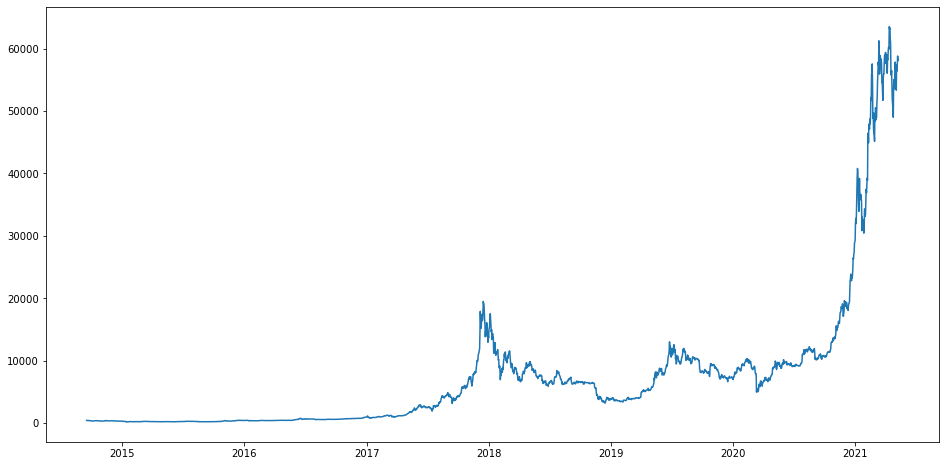

In [3]:
plt.figure(figsize=(16,8))
plt.plot(btc_hist["Close"],label = 'Close Price history')

###### **Create a new dataset ordered by date**

In [4]:
data=btc_hist.sort_index(ascending = True, axis = 0)
new_dataset=pd.DataFrame(index = range(0, len(btc_hist)), columns = ['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i] = data.index[i]
    new_dataset["Close"][i] = data["Close"][i]

###### **Set the Date column as the index**

In [5]:
new_dataset.index = new_dataset.Date
new_dataset.drop("Date", axis = 1, inplace = True)

###### **Create a scaler and the train - test data**

In [6]:
scaler = MinMaxScaler(feature_range = (0, 1))
final_dataset = new_dataset.values

data_size_75 = int(final_dataset.shape[0] * 0.75)

train_data = final_dataset[0:data_size_75,:]
valid_data = final_dataset[data_size_75:,:]

###### **Transform the dataset using the scaler**

In [7]:
scaled_data = scaler.fit_transform(final_dataset)

x_train_data, y_train_data = [],[]

for i in range(60, len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)

x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))

###### **Create the LSTM model**

In [8]:
lstm_model = Sequential()
lstm_model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train_data.shape[1],1)))
lstm_model.add(LSTM(units = 50))
lstm_model.add(Dense(1))

inputs_data = new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data = inputs_data.reshape(-1, 1)
inputs_data = scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(x_train_data, y_train_data, epochs = 1, batch_size = 1, verbose = 2)

1758/1758 - 126s - loss: 2.2605e-04


###### **Make the predictions**

In [ ]:
X_test = []
for i in range(60, inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_closing_price = lstm_model.predict(X_test)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

###### **Save the model for the future**

In [ ]:
lstm_model.save("saved_model.h5")

###### **Plot the results**

In [ ]:
train_data = new_dataset[:data_size_75]
valid_data = new_dataset[data_size_75:]
valid_data['Predictions'] = predicted_closing_price
plt.figure(figsize=(16,8))
plt.plot(train_data['Close'])
plt.plot(valid_data[['Close', 'Predictions']])